In [15]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta, TH
import matplotlib.pyplot as plt

In [16]:
def expiryDates():

    today = datetime.today()
    
    cmon = today.month
    if_month_next=(today + relativedelta(weekday=TH(1))).month
    next_thursday_expiry=today + relativedelta(weekday=TH(1))
   
    if (if_month_next!=cmon):
        month_last_thu_expiry= today + relativedelta(weekday=TH(5))
        if (month_last_thu_expiry.month!=if_month_next):
            month_last_thu_expiry= today + relativedelta(weekday=TH(4))
    else:
        for i in range(1, 7):
            t = today + relativedelta(weekday=TH(i))
            if t.month != cmon:
                # since t is exceeded we need last one  which we can get by subtracting -2 since it is already a Thursday.
                t = t + relativedelta(weekday=TH(-2))
                month_last_thu_expiry=t
                break
    str_month_last_thu_expiry=str(int(month_last_thu_expiry.strftime("%d")))+month_last_thu_expiry.strftime("%b").upper()+month_last_thu_expiry.strftime("%Y")
    str_next_thursday_expiry=str(int(next_thursday_expiry.strftime("%d")))+next_thursday_expiry.strftime("%b").upper()+next_thursday_expiry.strftime("%Y")
    return (str_next_thursday_expiry,str_month_last_thu_expiry)

In [17]:
weekly_expiry,monthly_expiry = expiryDates()

print("Next(Weekly) Expiry = " + weekly_expiry)
print("Monthly Expiry = " + monthly_expiry)

Next(Weekly) Expiry = 31DEC2020
Monthly Expiry = 31DEC2020


In [18]:
def topKOptionCalls(instrument,symbol,expirydate,k):

    urlheader = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36",
      "authority": "www.nseindia.com",
      "scheme":"https"
    }
    
    url="https://www1.nseindia.com/live_market/dynaContent/live_watch/option_chain/optionKeys.jsp?"
    params_index="segmentLink=17&instrument="+instrument+"&symbol="+symbol+"&date="
    params_stock=""
    
    url_encoded = url+params_index+expirydate
    req = requests.get(url_encoded, headers=urlheader)
    soup = BeautifulSoup(req.content, "lxml")
    table = soup.find('table', id="octable")
    
    rows = table.findAll('tr')
    header_text = []
    headers = rows[1]
    remove_indices_for_put = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,18,22]
    remove_indices_for_call = [0,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22]
     
    for th in headers.findAll('th'):
        header_text.append(th.text)
    
    header_text = [i for j, i in enumerate(header_text) if j not in remove_indices_for_put]
    df_call = pd.DataFrame(columns=header_text)
    df_put = pd.DataFrame(columns=header_text)
    
    for row in rows[2:-1]:
        row_text = []
        row_text_call = []
        row_text_put = []
        for row_element in row.findAll(['th', 'td']):
            row_text.append(row_element.text.replace('\n', '').strip())
    
        row_text_put = [i for j, i in enumerate(row_text) if j not in remove_indices_for_put]
        for i in range(len(row_text_put)):
            if (row_text_put[i]=='-'):
                row_text_put[i]=0
            else:
                row_text_put[i]=row_text_put[i].replace(',', '')
                row_text_put[i]=float(row_text_put[i])
        row_text_call = [i for j, i in enumerate(row_text) if j not in remove_indices_for_call]
        row_call_temp=[None] * len(row_text_call)
        for i in range(len(row_text_call)):       
            if (row_text_call[i]=='-'):
                row_call_temp[len(row_text_call)-i-1]=0
            else:
                row_text_call[i]=row_text_call[i].replace(',', '')
                row_text_call[i]=float(row_text_call[i])
                row_call_temp[len(row_text_call)-i-1]=row_text_call[i]
        df_call = df_call.append(pd.Series(dict(zip(df_call.columns, row_call_temp))), ignore_index=True)
        df_put = df_put.append(pd.Series(dict(zip(df_put.columns, row_text_put))), ignore_index=True)    
        
        
    df_call['OI'] = pd.to_numeric(df_call['OI'])
    df_call=df_call.nlargest(k, ['OI'])
    df_call.set_index('Strike Price', inplace=True)
    print("Top "+ str(k) +" Strike price of Call Option for "+ symbol +" based on Open Interest for Expiry Date = "+expirydate)
    df_call=df_call.sort_index(axis = 0) 
    print(df_call)
    
   
    df_call.plot.barh(title='Top '+ str(k)   +' Call Option for ' + symbol + ' based on OI for Option Expiry = '+expirydate)
    
    print("================================================================================") 
    df_put['OI'] = pd.to_numeric(df_put['OI'])
    df_put=df_put.nlargest(k, ['OI'])
    df_put.set_index('Strike Price', inplace=True)
    print("Top "+ str(k) +" Strike price of Put Option for " + symbol +" based on Open Interest for Expiry Date = "+expirydate)
    print(df_put)
    df_put=df_put.sort_index(axis = 0) 
    df_put.plot.barh( title='Top '+ str(k)  + ' Put Option for ' + symbol + ' based on OI for Option Expiry = '+expirydate)
    return(df_call,df_put)

## Top 5 option writing Calls for BANKNIFTY for next monthly expiry

Top 5 Strike price of Call Option for BANKNIFTY based on Open Interest for Expiry Date = 24DEC2020
               LTP     Volume  Chng in OI         OI
Strike Price                                        
30400.0       0.55  3089097.0    268700.0   860525.0
30500.0       0.05  5207938.0    470025.0  1527650.0
30600.0       0.05  3394702.0    568300.0   895425.0
30700.0       0.05  1962482.0    338550.0   679650.0
31000.0       0.05   739760.0   -220600.0   708475.0
Top 5 Strike price of Put Option for BANKNIFTY based on Open Interest for Expiry Date = 24DEC2020
               LTP     Volume  Chng in OI         OI
Strike Price                                        
30400.0       0.60  3290028.0    987125.0  1065650.0
28000.0       0.20   316698.0    256100.0  1060950.0
30000.0       0.05  2842123.0    690575.0   997525.0
29000.0       0.05   408790.0   -277125.0   860475.0
30300.0       0.05  2516863.0    804150.0   856700.0


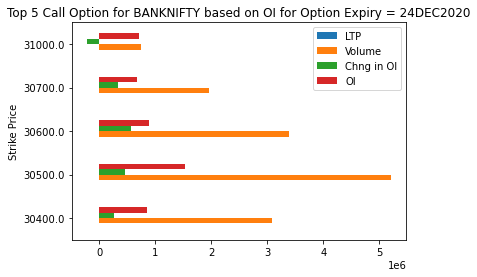

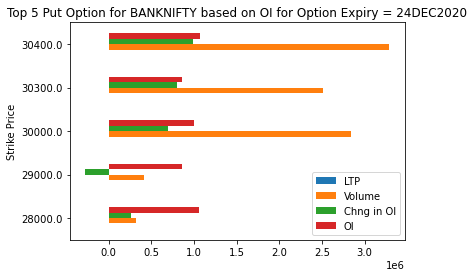

In [13]:
df_call_near_expiry,df_put_near_expiry = topKOptionCalls('OPTIDX','BANKNIFTY',weekly_expiry,5)

## Top 5 option writing Calls for NIFTY for next monthly expiry

Top 5 Strike price of Call Option for NIFTY based on Open Interest for Expiry Date = 24DEC2020
               LTP     Volume  Chng in OI         OI
Strike Price                                        
13750.0       0.05  2638656.0    477825.0  2450550.0
13800.0       0.05  1751976.0   1413975.0  4504125.0
13850.0       0.05   518821.0    891075.0  1652700.0
13900.0       0.05   254093.0    280350.0  2104350.0
14000.0       0.05   220750.0   -335475.0  2810625.0
Top 5 Strike price of Put Option for NIFTY based on Open Interest for Expiry Date = 24DEC2020
               LTP     Volume  Chng in OI         OI
Strike Price                                        
13700.0       0.05  2134816.0   2722500.0  3191625.0
13000.0       0.05   186706.0   -771375.0  3023325.0
13500.0       0.05   943430.0   -196725.0  2770500.0
13600.0       0.05  1827335.0   1104975.0  2622525.0
13400.0       0.05   453793.0   -489150.0  2296500.0


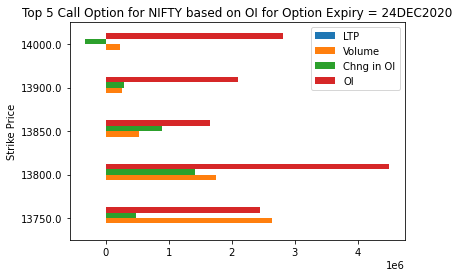

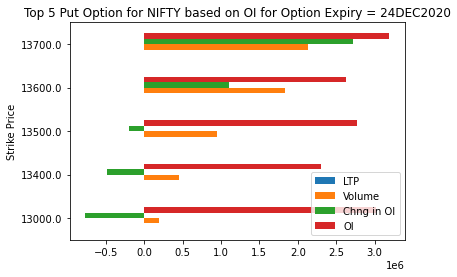

In [14]:
df_call_near_expiry,df_put_near_expiry = topKOptionCalls('OPTIDX','NIFTY',weekly_expiry,5)

## Top 5 option writing Calls for HDFCBANK for next monthly expiry

Top 5 Strike price of Call Option for HDFCBANK based on Open Interest for Expiry Date = 31DEC2020
                LTP  Volume  Chng in OI         OI
Strike Price                                      
1380.0        20.90  6809.0    401500.0   936650.0
1400.0        12.35  6133.0    190300.0  1324400.0
1420.0         7.00  2490.0     42350.0  1123650.0
1440.0         4.45  1991.0     23100.0  1279850.0
1500.0         1.70   489.0      7150.0  1183600.0
Top 5 Strike price of Put Option for HDFCBANK based on Open Interest for Expiry Date = 31DEC2020
                LTP  Volume  Chng in OI        OI
Strike Price                                     
1400.0        32.05   528.0     -1650.0  787050.0
1300.0         3.25  1136.0     66000.0  710600.0
1380.0        20.60  1782.0     45100.0  707300.0
1420.0        47.30    72.0     -3300.0  498300.0
1340.0         7.80  3075.0      3300.0  497750.0


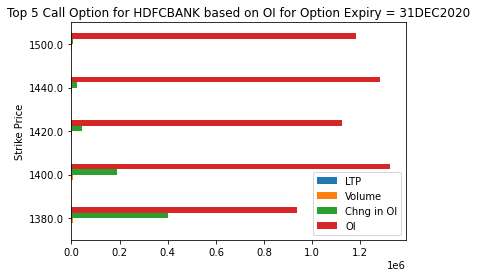

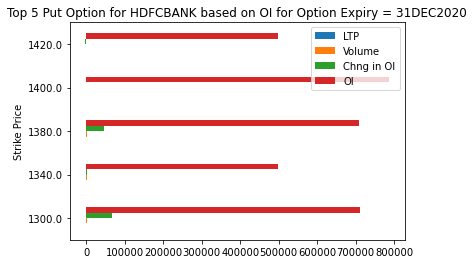

In [7]:
df_call_near_expiry,df_put_near_expiry = topKOptionCalls('OPTSTK','HDFCBANK',monthly_expiry,5)

Top 5 Strike price of Call Option for RELIANCE based on Open Interest for Expiry Date = 31DEC2020
                LTP   Volume  Chng in OI         OI
Strike Price                                       
2000.0        19.40  16808.0     70700.0  5026770.0
2050.0        10.20   9533.0    -26260.0  4980815.0
2100.0         5.75   7366.0   -112110.0  4857090.0
2200.0         2.80   3191.0   -104030.0  2539140.0
2300.0         1.65    903.0    -70195.0  1768005.0
Top 5 Strike price of Put Option for RELIANCE based on Open Interest for Expiry Date = 31DEC2020
                LTP  Volume  Chng in OI         OI
Strike Price                                      
1900.0        17.50  8246.0    -16665.0  1811940.0
2000.0        69.00  1418.0    -65145.0  1492275.0
1800.0         3.80  3896.0   -142915.0  1414000.0
1950.0        36.85  3800.0    140390.0  1163520.0
1850.0         7.75  4990.0     51005.0  1035250.0


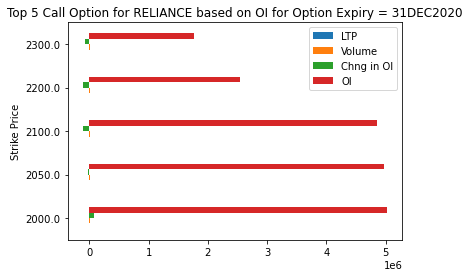

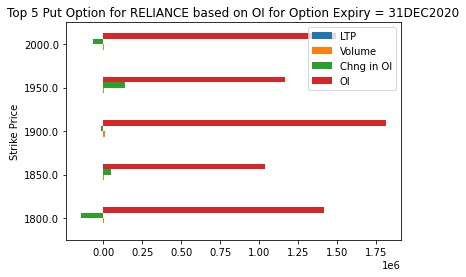

In [8]:
df_call_near_expiry,df_put_near_expiry = topKOptionCalls('OPTSTK','RELIANCE',monthly_expiry,5)